In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
r = 0.05
gamma = 1./(1+r)
wood_unit_price = 1
new_tree_price = 5
maintenance_cost = 0.5
max_height = 20
max_growth = 5
disease_probability = 0.2

Thus, the random effect are modeled the following way:
- i) A tree has a probability disease_probability (=0.2) to get a disease at each t (except it is already in a sick state and it stays sick except if we cut it).
- ii) The effect of the weather is modeled by a random growth: a tree will grow of a value uniformly selected between 1 and max_growth, but it can’t be taller than max_height (exemple: if the height is 18, so for a growth of 2, 3 , 4 and 5, the final height will be max_height= 20).

In [3]:
def tree_sim(x,a):
    y=x
    r=0
    if a == "cut":
        y = 1
        r = x*wood_unit_price - new_tree_price
    elif a == "no cut":
        disease_random = random.uniform(0,1)
        if disease_random > disease_probability :
            growth = random.randint(1,max_growth)
            y = min(x+growth,max_height)
            r = -maintenance_cost
        else:
            r = -maintenance_cost - new_tree_price
            y = 1
        
    return  y,r

In [4]:
def tree_MDP():
    dynamics = np.zeros((max_height,max_height,2))
    for i in range(max_height):
        dynamics[i,0,1] = 1 
        dynamics[i,0,0] = 0.2
        for j in range(i+1,min(i + max_growth + 1,max_height)):
                dynamics[i,j,0]= (1-disease_probability)/max_growth 
        if max_height-1 - i < max_growth:
            dynamics[i,max_height-1,0] = (1-disease_probability)*(max_growth -(max_height-2-i))/max_growth
    dynamics[max_height-1,max_height-1,0]= (1-disease_probability)
    rewards = np.zeros((max_height,2))
    for i in range(max_height):
        rewards[i,1]= (i+1)*wood_unit_price - new_tree_price
    rewards[:,0]= rewards[:,0] - maintenance_cost
    return dynamics,rewards

In [5]:
def monte_Carlo_estimation(dynamics,rewards,policy_decision):
    V_0 = 0
    r_pi = np.zeros((max_height))
    for i in range(max_height):
        r_pi[i]= rewards[i,policy_decision[i]]
    M = np.zeros(1000)
    for  nb_iter in range(1000):
        r_trajectory = 0
        y = 1
        for t in range(1000):
            if policy_decision[y-1]==1:
                a="cut"
            else:
                a="no cut"
            y, r = tree_sim(y,a)
            r_trajectory += (gamma**t)*r
        V_0 =  V_0 + r_trajectory
        M[nb_iter] = r_trajectory
    V_0 = V_0/1000
    return V_0,M 

def V_estimate_matrix_inversion(dynamics,rewards,policy_decision):
    P = np.ones((max_height,max_height))
    r_pi = np.zeros((max_height))
    for i in range(max_height):
        r_pi[i]= rewards[i,policy_decision[i]]
    for i in range(max_height):
        for j in range(max_height):
            P[i,j] = dynamics[i,j,policy_decision[i]]
    result = np.dot(np.linalg.inv(np.identity(max_height) - gamma*P),r_pi)
    return result
        

In [6]:
dynamics,rewards = tree_MDP()
policy =  np.zeros(max_height)
for i in range(max_height):
    if i> 14:
        policy[i]=1
value,M = monte_Carlo_estimation(dynamics,rewards,policy)

/Users/arielhaziza/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [7]:
V_estimate_matrix_inversion(dynamics,rewards,policy)

/Users/arielhaziza/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/arielhaziza/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


array([  7.98953005,   8.33084632,   8.70353447,   9.10873512,
         9.54701372,  10.03549877,  10.5707343 ,  11.14930047,
        11.76786441,  12.42321703,  13.24118188,  14.0832175 ,
        14.94614097,  15.82719026,  16.72396857,  18.60907624,
        19.60907624,  20.60907624,  21.60907624,  22.60907624])

In [8]:
value

-11.049596439138769

In [9]:
MC_average_trajectory = np.zeros(1000)
for i in range(10):
    MC_average_trajectory += monte_Carlo_estimation(dynamics,rewards,policy)[1]
MC_average_trajectory = MC_average_trajectory/10
for i in range(MC_average_trajectory.shape[0]):
    MC_average_trajectory[i]=np.mean(MC_average_trajectory[0:i+1])


/Users/arielhaziza/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/Users/arielhaziza/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/arielhaziza/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


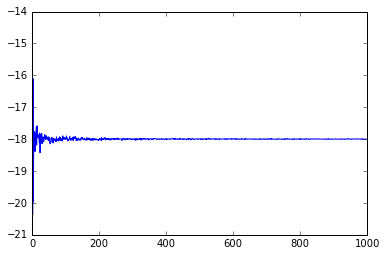

In [10]:
difference = MC_average_trajectory - V_estimate_matrix_inversion(dynamics,rewards,policy)[0]
plt.plot(range(1000),difference)

### Q3- Optimal policy

In [11]:
def policy_iteration(dynamics,rewards):
    policy = np.zeros(max_height)
    policy_bis = (-1)* np.ones(max_height)
    nb_iter = 0
    M = np.zeros((20,1000))
    while not((policy==policy_bis).all()):
        nb_iter +=1
        temp = policy_bis
        policy_bis = (-1)* np.ones(max_height)
        policy = temp
        for i in range(max_height):
            v_pi = V_estimate_matrix_inversion(dynamics,rewards,policy)
            value_0 = rewards[i,0]+ gamma*np.dot(dynamics[i,:,0],v_pi)
            value_1 = rewards[i,1]+ gamma*np.dot(dynamics[i,:,1],v_pi)
            if value_1 > value_0:
                policy_bis[i]=1
            else:
                policy_bis[i]=0
        M[:,nb_iter-1]= v_pi
    print("Nombre d iterations: %d"%nb_iter)
    M = M[:,0:nb_iter]
    return policy,M

In [12]:
polcy_from_PI, v_PI = policy_iteration(dynamics,rewards)

Nombre d iterations: 4


/Users/arielhaziza/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/arielhaziza/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [13]:
def bellman_operator(dynamics,rewards,v):
    result = np.zeros(max_height)
    for i in range(max_height):
        value_0 = rewards[i,0]+ gamma*np.dot(dynamics[i,:,0],v)
        value_1 = rewards[i,1]+ gamma*np.dot(dynamics[i,:,1],v)
        if value_1 > value_0:
            result[i] = value_1
        else:
            result[i] = value_0
    return result
        
def value_iteration(dynamics,rewards):
    v  = np.zeros(max_height)
    pi = np.zeros(max_height)
    M = np.zeros((max_height,1000))
    for i in range(1000):
        v = bellman_operator(dynamics,rewards,v)
        M[:,i]= v
    for i in range(max_height):
        value_0 = rewards[i,0]+ gamma*np.dot(dynamics[i,:,0],v)
        value_1 = rewards[i,1]+ gamma*np.dot(dynamics[i,:,1],v)
        if value_1 > value_0:
            pi[i] = 1
    return pi,M
        
        

In [14]:
optimal_policy_VI, v_VI = value_iteration(dynamics,rewards)
V_optimal = V_estimate_matrix_inversion(dynamics,rewards,optimal_policy_VI)

/Users/arielhaziza/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/arielhaziza/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


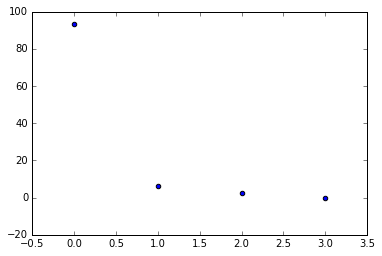

In [15]:
difference_PI = np.zeros(v_PI.shape[1])
for i in range(v_PI.shape[1]):
    difference_PI[i] = np.max(np.abs(v_PI[:,i]-V_optimal))
plt.scatter(range(v_PI.shape[1]),difference_PI)

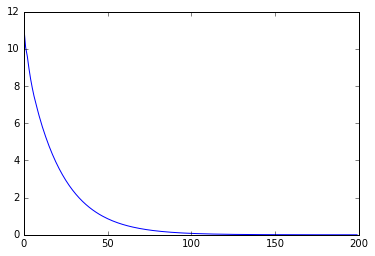

In [16]:
difference_VI = np.zeros(v_VI.shape[1])
for i in range(v_VI.shape[1]):
    difference_VI[i] = np.max(np.abs(v_VI[:,i]-V_optimal))
plt.plot(range(200),difference_VI[0:200])

In [21]:
value,M = monte_Carlo_estimation(dynamics,rewards,policy)
    

/Users/arielhaziza/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Thus, the policy iteration (PI) converges in 5 iterations whereas the value iteration (VI) requires a little more than 100 iterations to converge. Then, PI looks like more efficient than VI. 


Nevertheless, PI requires an admissible policy to initialize whereas it is not the case for VI. And PI is greedy so the rapidity of convergence will depend on the initialization value.
Furthermore, PI requires at each iteration to inverse a new matrix so it has a more important computational cost than VI.